# This file calculates the MNAD values for the IEEE SM 1354


In [1]:
 import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import optimizers, models, regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, Input
from tensorflow.keras.layers import Input, Dense, LSTM, Lambda, Dropout, GRU,SimpleRNN
from tensorflow.keras.layers import Flatten, Dense,Dropout
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from numpy.linalg import norm
from scipy import stats

(3000, 2708)
(900, 2708)


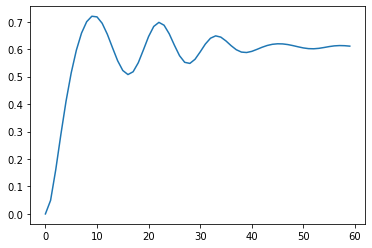

In [2]:
def outliers(df, int):
  z_scores = stats.zscore(df)
  abs_z_scores = np.abs(z_scores)
  filtered_entries = (abs_z_scores < int).all(axis=1)
  df = df[filtered_entries]
  return df
def coeff_determination(y_pred, y_true): #Order of function inputs is important here        
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# importing data 
import scipy.io as sio
train= sio.loadmat('snaps_train.mat')   # load the desired model
snapshots_train=train['snaps_train'].T
#valid= sio.loadmat('xFOM_valid.mat')   # load the desired model
#snapshots_valid=valid['xFOM_valid']
test= sio.loadmat('snaps_test.mat')   # load the desired model
snapshots_all=test['snaps_test']
tspan=60
set=50
snapshots_train=snapshots_train[:,:]
snapshots_valid=snapshots_all[0:tspan,:]
snapshots_train=outliers(snapshots_train,10)
print (snapshots_train.shape)
print (snapshots_all.shape)
plt.plot(snapshots_train[0:tspan,1])
plt.show()


In [3]:
latent_dim=13 # or 8
input=output=snapshots_train.shape[1]
first=input
second=2048
encoder_input = Input(shape=(input, 1), name='IEEE300')
o1 = Flatten()(encoder_input)
o2 = Dense(first, activation="relu")(o1)
o3 = Dense(second, activation="relu")(o2)

encoder_output = Dense(latent_dim, activation=None)(o3)
encoder = Model(encoder_input, encoder_output, name='encoder')
#encoder.summary()
decoder_input = Dense(latent_dim, activation='relu')(encoder_output)
decoder_input2 = Dense(second, activation='relu')(decoder_input)
decoder_input3= Dense(first, activation='relu')(decoder_input2)

decoder_output = Dense(output, activation=None)(decoder_input3)
decoder = Model(decoder_input, decoder_output, name='decoder')
ae_output=decoder(encoder(encoder_input))
autoencoder = Model(encoder_input, ae_output, name='autoencoder')
autoencoder.summary()
weights_filepath = 'AE_weightsMNAD10.h5'

# design network
lrate = 0.001
my_adam = optimizers.Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

checkpoint = ModelCheckpoint(weights_filepath, monitor='loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
earlystopping = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpoint]
epoch_num=2000
batch_size=set
autoencoder.compile(optimizer=my_adam, loss='MeanSquaredError',metrics=[coeff_determination,'accuracy'])
#autoencoder.fit(snapshots_train, snapshots_train,
 #               epochs=epoch_num,  batch_size=batch_size,
  #                        callbacks=callbacks_list
   #             ,validation_data=(snapshots_valid, snapshots_valid))
               # shuffle=True)
autoencoder.load_weights(weights_filepath)
#encoded_test = K.eval(encoder(snapshots_test.astype('float32')))
#autoencoder_output = autoencoder.predict(snapshots_test)

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 IEEE300 (InputLayer)        [(None, 2708, 1)]         0         
                                                                 
 encoder (Functional)        (None, 13)                12910641  
                                                                 
 decoder (Functional)        (None, 2708)              12913336  
                                                                 
Total params: 25,823,977
Trainable params: 25,823,977
Non-trainable params: 0
_________________________________________________________________


C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [5]:
# generate encoded data for lstm
rnum_vals_train=set # batch size
num_time_steps=tspan
encoded_train = K.eval(encoder(snapshots_train.astype('float32')))
# Reshape
lstm_training_data = encoded_train.reshape(rnum_vals_train,num_time_steps,latent_dim)
num_train_snapshots=rnum_vals_train
time_window=10 #try
total_size = np.shape(lstm_training_data)[0]*np.shape(lstm_training_data)[1] # 45*600=27000
total_size_sim = np.shape(lstm_training_data)[1]                             # 600
input_seq = np.zeros(shape=(total_size-num_train_snapshots*time_window
                           ,time_window,latent_dim))
output_seq = np.zeros(shape=(total_size-num_train_snapshots*time_window,latent_dim))
# Setting up inputs
sample = 0
for snum in range(num_train_snapshots):
    for t in range(time_window,total_size_sim):
        input_seq[sample,:,:] = lstm_training_data[snum,t-time_window:t,:]
        output_seq[sample,:] = lstm_training_data[snum,t,0:latent_dim]
        sample = sample + 1

In [6]:
# generate validation data for lstm
rnum_vals_train=1 # batch size
num_time_steps=tspan
num_train_snapshots=rnum_vals_train
encoded_train=outliers(encoded_train,10)
# Reshape
encoded_valid=K.eval(encoder(snapshots_valid.astype('float32')))
lstm_training_data_valid = encoded_valid.reshape(rnum_vals_train,num_time_steps,latent_dim)
total_size_valid = np.shape(lstm_training_data_valid)[0]*np.shape(lstm_training_data_valid)[1] # 45*600=27000
total_size_sim_valid = np.shape(lstm_training_data_valid)[1]                             # 600
input_seq_valid = np.zeros(shape=(total_size_valid-num_train_snapshots*time_window
                           ,time_window,latent_dim))
output_seq_valid = np.zeros(shape=(total_size_valid-num_train_snapshots*time_window,latent_dim))
# Setting up inputs
sample = 0
for snum in range(num_train_snapshots):
    for t in range(time_window,total_size_sim_valid):
        input_seq_valid[sample,:,:] = lstm_training_data_valid[snum,t-time_window:t,:]
        output_seq_valid[sample,:] = lstm_training_data_valid[snum,t,0:latent_dim]
        sample = sample + 1

In [7]:
# Model architecture
units=40
lstm_model = models.Sequential()
lstm_model.add(LSTM(units,input_shape=(time_window, latent_dim),return_sequences=True))
#lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units,input_shape=(time_window, latent_dim),return_sequences=True))
#lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units,input_shape=(time_window, latent_dim),return_sequences=True))
#lstm_model.add(Dropout(0.2))
#lstm_model.add(LSTM(units,input_shape=(time_window, latent_dim),return_sequences=True))
#lstm_model.add(LSTM(units,return_sequences=True))
lstm_model.add(LSTM(units,return_sequences=False))
#lstm_model.add(Dropout(0.1))#try # 80 showing best response
#lstm_model.add(LSTM(units,return_sequences=False))
#lstm_model.add(Dropout(0.1))#
#lstm_model.add(LSTM(80,return_sequences=False))
#lstm_model.add(LSTM(40,input_shape=(time_window, latent_dim),return_sequences=False))
lstm_model.add(Dense(latent_dim, activation=None))

# design network
lstm_filepath = 'lstm_weightsMNAD10.h5'
lstm_adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
checkpoint = ModelCheckpoint(lstm_filepath, monitor='loss', verbose=0, save_best_only=True, mode='min',save_weights_only=True)
earlystopping = EarlyStopping(monitor='loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
lstm_callbacks_list = [checkpoint]
# fit network
lstm_model.compile(optimizer=lstm_adam,loss='mean_squared_error')

lstm_model.summary()
#if mode == 'train':
# training parameters
batch_size_lstm=set # try batch size=590
num_epochs = 2000 # try
#lstm_train_history = lstm_model.fit(input_seq,output_seq, epochs=num_epochs, 
 #                                   batch_size=batch_size_lstm, callbacks=lstm_callbacks_list   #,shuffle=True
  #                                ,validation_data=[input_seq_valid,output_seq_valid] )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 40)            8640      
                                                                 
 lstm_1 (LSTM)               (None, 10, 40)            12960     
                                                                 
 lstm_2 (LSTM)               (None, 10, 40)            12960     
                                                                 
 lstm_3 (LSTM)               (None, 40)                12960     
                                                                 
 dense_7 (Dense)             (None, 13)                533       
                                                                 
Total params: 48,053
Trainable params: 48,053
Non-trainable params: 0
_________________________________________________________________


# Testing

In [8]:
# Calculating MNADs
def MNAD(y_true,y_pred):
    Nx=y_true.shape[1] #columns=dims
    Nt=y_true.shape[0] # rows = time
    F=np.zeros(shape=(Nt,Nx))
    for i in range(Nx):
         F[:,i]=abs(y_true[:,i]-y_pred[:,i])/ (max(y_true[:,i])- min(y_true[:,i]))
    NAD=F.mean(axis=1)        
    return NAD.mean()
#print(MNAD(snapshots_test,decoded_lstm))  

In [10]:
# Calculation of Decoded values and MNADs
loop=int(snapshots_all.shape[0]/tspan)#49
d=int(snapshots_train.shape[1]/2) # no of dimensions (features)
rnum_vals_test=1
num_time_steps=tspan
lstm_model.load_weights(lstm_filepath)
#rnum_vals_test=300
#time_window=4
#Norm_delta=np.zeros(shape=(1,loop-1))
#Norm_omega=np.zeros(shape=(1,loop-1))
MNAD_delta=np.zeros(shape=(1,loop-1))
MNAD_omega=np.zeros(shape=(1,loop-1))
for i in range(1,loop):
    print('Running testing for i =', i, ' of ', loop)
    snapshots_test=snapshots_all[(i)*tspan:i*tspan+tspan,:]
    encoded_test = K.eval(encoder(snapshots_test.astype('float32')))    
    # data for testing LSTM
    num_test_snapshots=rnum_vals_test
    lstm_testing_data = encoded_test.reshape(rnum_vals_test,num_time_steps,latent_dim)
    #scaler = MinMaxScaler()
    #stm_testing_data[0,:,:]=scaler.fit_transform(lstm_testing_data[0,:,:])
    total_size = np.shape(lstm_testing_data)[0]*np.shape(lstm_testing_data)[1]
    total_size_sim = np.shape(lstm_testing_data)[1]
    # Shape the inputs and outputs
    input_seq = np.zeros(shape=(1,time_window,latent_dim))
    output_seq = np.zeros(shape=(total_size-num_test_snapshots*time_window,latent_dim))
    output_seq_pred = np.zeros(shape=(total_size-num_test_snapshots*time_window,latent_dim))
    lstm_model.load_weights(lstm_filepath)
    # Setting up inputs
    sample = 0
    print('Running LSTM...')
    for snum in range(num_test_snapshots):
        input_seq[0,:,:] = lstm_testing_data[snum,0:time_window,:]
        for t in range(time_window,total_size_sim):
            #input_seq[0,:,:] = lstm_testing_data[snum,t-time_window:t,:]
            output_seq_pred[sample,:] = lstm_model.predict(input_seq[0:latent_dim,:,:])[0,:]   # [0,:]
            output_seq[sample,:] = lstm_testing_data[snum,t,0:latent_dim]
            input_seq[0,0:time_window-1,:] = input_seq[0,1:,:] 
            input_seq[0,time_window-1,:latent_dim] = output_seq_pred[sample,:]
            sample = sample + 1
    output_seq_pred = np.concatenate((encoded_test[0:time_window,:],output_seq_pred),axis=0)
    decoded_lstm= K.eval(decoder(output_seq_pred.astype('float32')))
    #Norm_delta[:,:]=norm(snapshots_test[:,:d]-decoded_lstm[:,:d])/norm(snapshots_test[:,:d])
   # Norm_omega[:,:]=norm(snapshots_test[:,d:]-decoded_lstm[:,d:])/norm(snapshots_test[:,d:])
    MNAD_delta[:,i-1]=MNAD(snapshots_test[:,:d],decoded_lstm[:,:d])
    MNAD_omega[:,i-1]=MNAD(snapshots_test[:,d:],decoded_lstm[:,d:])                   
    

Running testing for i = 1  of  15
Running LSTM...
Running testing for i = 2  of  15
Running LSTM...
Running testing for i = 3  of  15
Running LSTM...
Running testing for i = 4  of  15
Running LSTM...
Running testing for i = 5  of  15
Running LSTM...
Running testing for i = 6  of  15
Running LSTM...
Running testing for i = 7  of  15
Running LSTM...
Running testing for i = 8  of  15
Running LSTM...
Running testing for i = 9  of  15
Running LSTM...
Running testing for i = 10  of  15
Running LSTM...
Running testing for i = 11  of  15
Running LSTM...
Running testing for i = 12  of  15
Running LSTM...
Running testing for i = 13  of  15
Running LSTM...
Running testing for i = 14  of  15
Running LSTM...


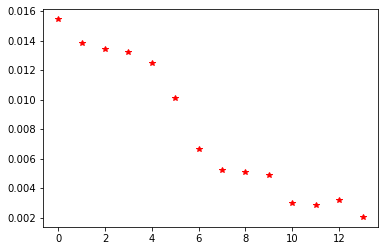

In [14]:
plt.plot(MNAD_delta.T,'r*')
#plt.plot(MNAD_omega.T,'k*')
plt.title('MNAD error of deltas for range of data sets')
plt.savefig('Results/MNAD_delta')

In [ ]:
plt.plot(MNAD_omega.T,'r*')
plt.title('MNAD error of omegas for range of data sets')
plt.savefig('Results/MNAD_omega')